In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [2]:
X, Y = load_planar_dataset()

In [3]:
X.shape

(2, 400)

In [4]:
Y.shape

(1, 400)

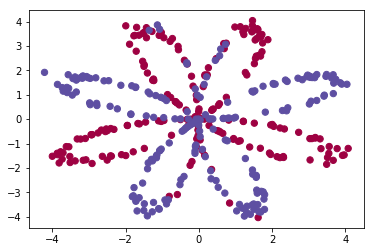

In [5]:
# 绘制样本
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

In [6]:
assert(X.shape[1] == Y.shape[1])
m = X.shape[1]
n = X.shape[0]
print('样本数量 m =', m)
print('输入特征数量 n =', n)

样本数量 m = 400
输入特征数量 n = 2


In [7]:
# def sigmoid(Z):
#     return 1 / (1 + np.exp(-Z))
def sigmoid(Z):
    return 0.5 * (1 + np.tanh(0.5 * Z))

In [8]:
def sigmoid_derivative(Z):
    A = sigmoid(Z)
    return A * (1 - A)

### 1层神经网络（逻辑回归）

In [9]:
# 初始化权重矩阵W 偏移向量b
def initialize_parameters(n_x, n_y):
    W = np.random.randn(n_y, n_x) * 0.01
    b = np.zeros((n_y, 1))
    return W, b

In [10]:
# 计算正反向传播
def propagate(W, b, X, Y):
    assert(X.shape[1] == Y.shape[1])
    
    # 样本数量
    m = X.shape[1]
    
    # 正向传播
    A = sigmoid(W @ X + b)
    
    # 计算损失函数
    logprobs = Y * np.log(A) + (1 - Y) * np.log(1 - A)
    cost = -np.nanmean(logprobs)
    
    # 反向传播
    dZ = A - Y
    dW = (dZ @ X.T) / m
    db = np.mean(dZ, axis=1, keepdims=True)
    
    assert(dW.shape == W.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    # 梯度
    grads = {"dW": dW,
             "db": db}
    
    return grads, cost

In [11]:
# 用训练集训练模型
def model(X, Y, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # 初始化参数 W b
    W, b = initialize_parameters(X.shape[0], Y.shape[0])
    
    # 梯度下降法循环迭代
    for i in range(num_iterations):
        grads, cost = propagate(W, b, X, Y)
        W -= learning_rate * grads["dW"]
        b -= learning_rate * grads["db"]
        if i % 100 == 0 and print_cost:
            print("Cost after iteration %i: %f" %(i, cost))
    
    return W, b 

In [12]:
# 对样本进行预测
def predict(W, b, X):
    A = sigmoid(W @ X + b) > 0.5
    return A.astype(np.int)

In [13]:
# 训练神经网络模型
W, b = model(X, Y, num_iterations = 1000, learning_rate = 0.5, print_cost=True)
W, b

Cost after iteration 0: 0.694565
Cost after iteration 100: 0.673146
Cost after iteration 200: 0.673146
Cost after iteration 300: 0.673146
Cost after iteration 400: 0.673146
Cost after iteration 500: 0.673146
Cost after iteration 600: 0.673146
Cost after iteration 700: 0.673146
Cost after iteration 800: 0.673146
Cost after iteration 900: 0.673146


(array([[ 0.02809092, -0.20318475]]), array([[ 0.01555503]]))

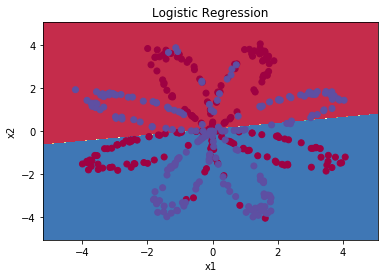

In [14]:
# 绘制决策边界图
plot_decision_boundary(lambda x: predict(W, b, x.T), X, Y[0])
plt.title("Logistic Regression");

In [15]:
# 打印训练集的准确率
predictions = predict(W, b, X)
print ('准确率: %d' % float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100) + '%')

准确率: 47%


### 2层神经网络（隐藏层tanh 输出层sigmoid）

In [16]:
# 初始化隐藏层和输出层的权重矩阵W 偏移向量b
def initialize_parameters(n_x, n_h, n_y):
    # 第1层隐藏层 W b
    W1 = np.random.randn(n_h, n_x) * 0.001
    b1 = np.zeros((n_h, 1))
    # 第2层输出层 W b
    W2 = np.random.randn(n_y, n_h) * 0.001
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [17]:
# 计算正反向传播 损失函数 隐藏层tanh 输出层sigmoid
def propagation(X, Y, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 正向传播
    Z1 = W1 @ X + b1
    A1 = np.tanh(Z1)
    Z2 = W2 @ A1 + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    # 损失函数
    cost = -np.mean(Y * np.log(A2) + (1 - Y) * np.log(1 - A2))
    cost = np.squeeze(cost)
    assert(isinstance(cost, float))
    
    # 反向传播
    dZ2 = A2 - Y
    dW2 = dZ2 @ A1.T / dZ2.shape[1]
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T @ dZ2 * (1 - A1**2)
    dW1 = dZ1 @ X.T / dZ1.shape[1]
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return A2, grads, cost

In [18]:
# 用梯度下降法更新参数
def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [19]:
# 2层神经网络模型训练
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):
    # 初始化 W1 b1 W2 b2
    parameters = initialize_parameters(X.shape[0], n_h, Y.shape[0])
    
    # 梯度下降法循环迭代
    for i in range(0, num_iterations):
        A2, grads, cost = propagation(X, Y, parameters)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return parameters

In [20]:
# 对样本进行预测
def predict(parameters, X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 正向传播
    Z1 = W1 @ X + b1
    A1 = np.tanh(Z1)
    Z2 = W2 @ A1 + b2
    A2 = sigmoid(Z2)
    
    predictions = A2 > 0.5
    
    return predictions.astype(np.int)

In [21]:
# 训练神经网络模型
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, learning_rate = 1.2, print_cost=True)
parameters

Cost after iteration 0: 0.693147
Cost after iteration 1000: 0.256751
Cost after iteration 2000: 0.238709
Cost after iteration 3000: 0.230443
Cost after iteration 4000: 0.225284
Cost after iteration 5000: 0.221664
Cost after iteration 6000: 0.218955
Cost after iteration 7000: 0.220597
Cost after iteration 8000: 0.219359
Cost after iteration 9000: 0.218442


{'W1': array([[ 11.47762345,  -3.42269719],
        [ 11.52754794,  13.48326225],
        [  0.1552088 ,  -9.71500241],
        [ -9.27454413,  10.21408438]]),
 'W2': array([[ -3.45813349,  -6.12961533, -12.00281836, -10.57396146]]),
 'b1': array([[ 0.41215158],
        [ 0.06457672],
        [ 0.01625665],
        [-0.01512129]]),
 'b2': array([[-0.06765738]])}

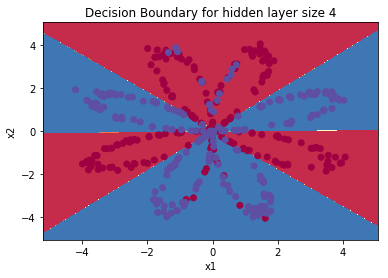

In [22]:
# 绘制决策边界图
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
plt.title("Decision Boundary for hidden layer size " + str(4));

In [23]:
# 打印训练集的准确率
predictions = predict(parameters, X)
print ('准确率: %d' % float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100) + '%')

准确率: 90%


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.75 %
Accuracy for 5 hidden units: 90.75 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.75 %


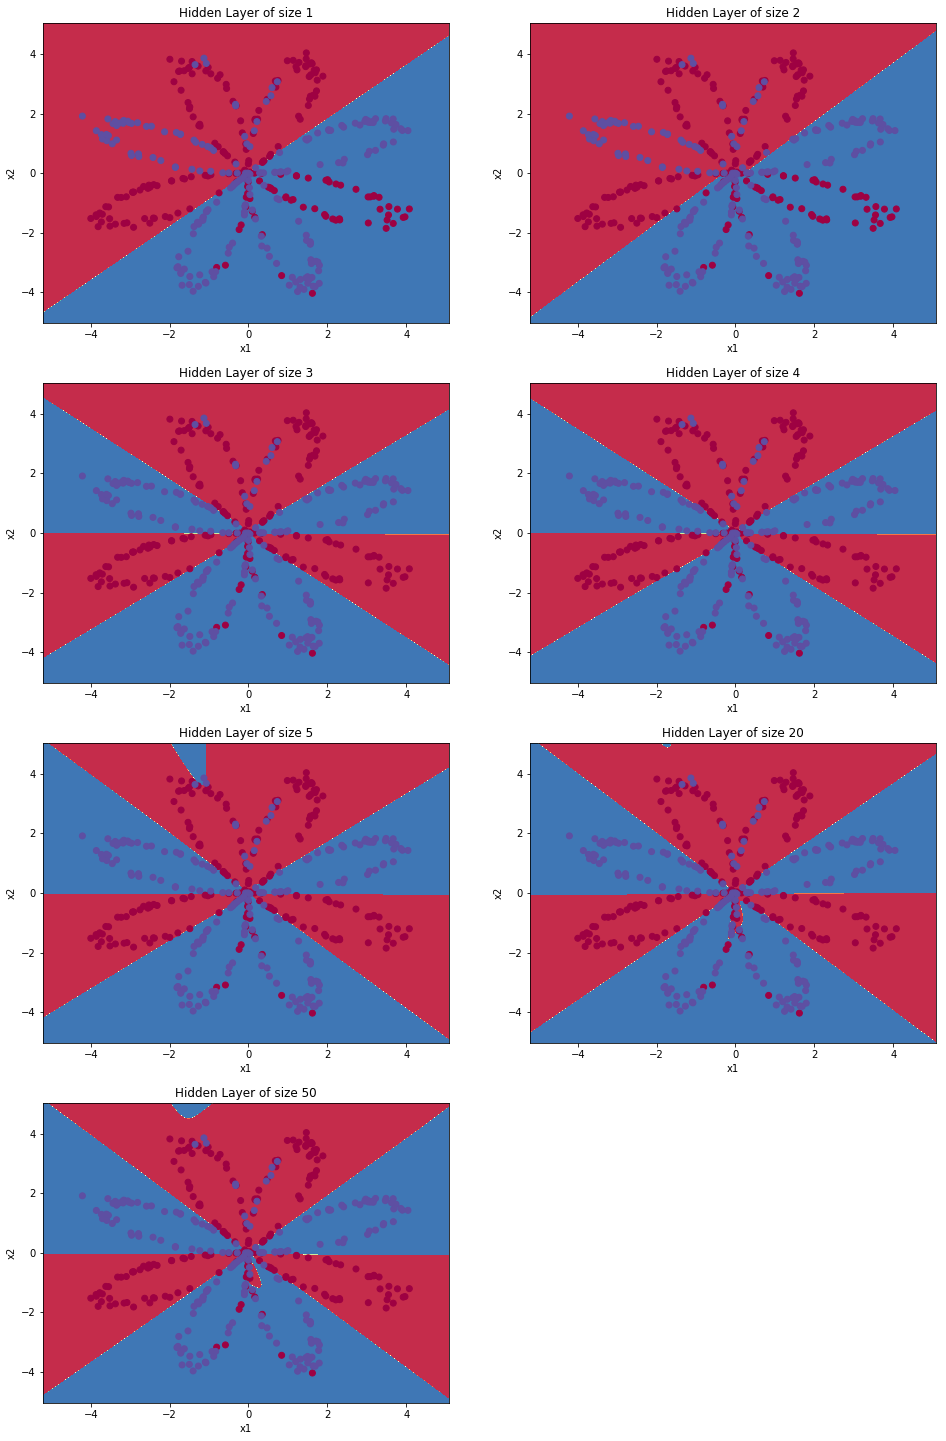

In [24]:
# 隐藏层节点数量调参
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

### 其他数据集

In [25]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

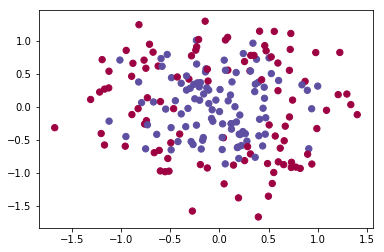

In [26]:
X, Y = noisy_circles
X, Y = X.T, Y.reshape(1, Y.shape[0])

# 绘制样本
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

Accuracy for 1 hidden units: 62.0 %
Accuracy for 2 hidden units: 71.5 %
Accuracy for 3 hidden units: 77.0 %
Accuracy for 4 hidden units: 78.5 %
Accuracy for 5 hidden units: 79.0 %
Accuracy for 20 hidden units: 79.5 %
Accuracy for 50 hidden units: 78.0 %


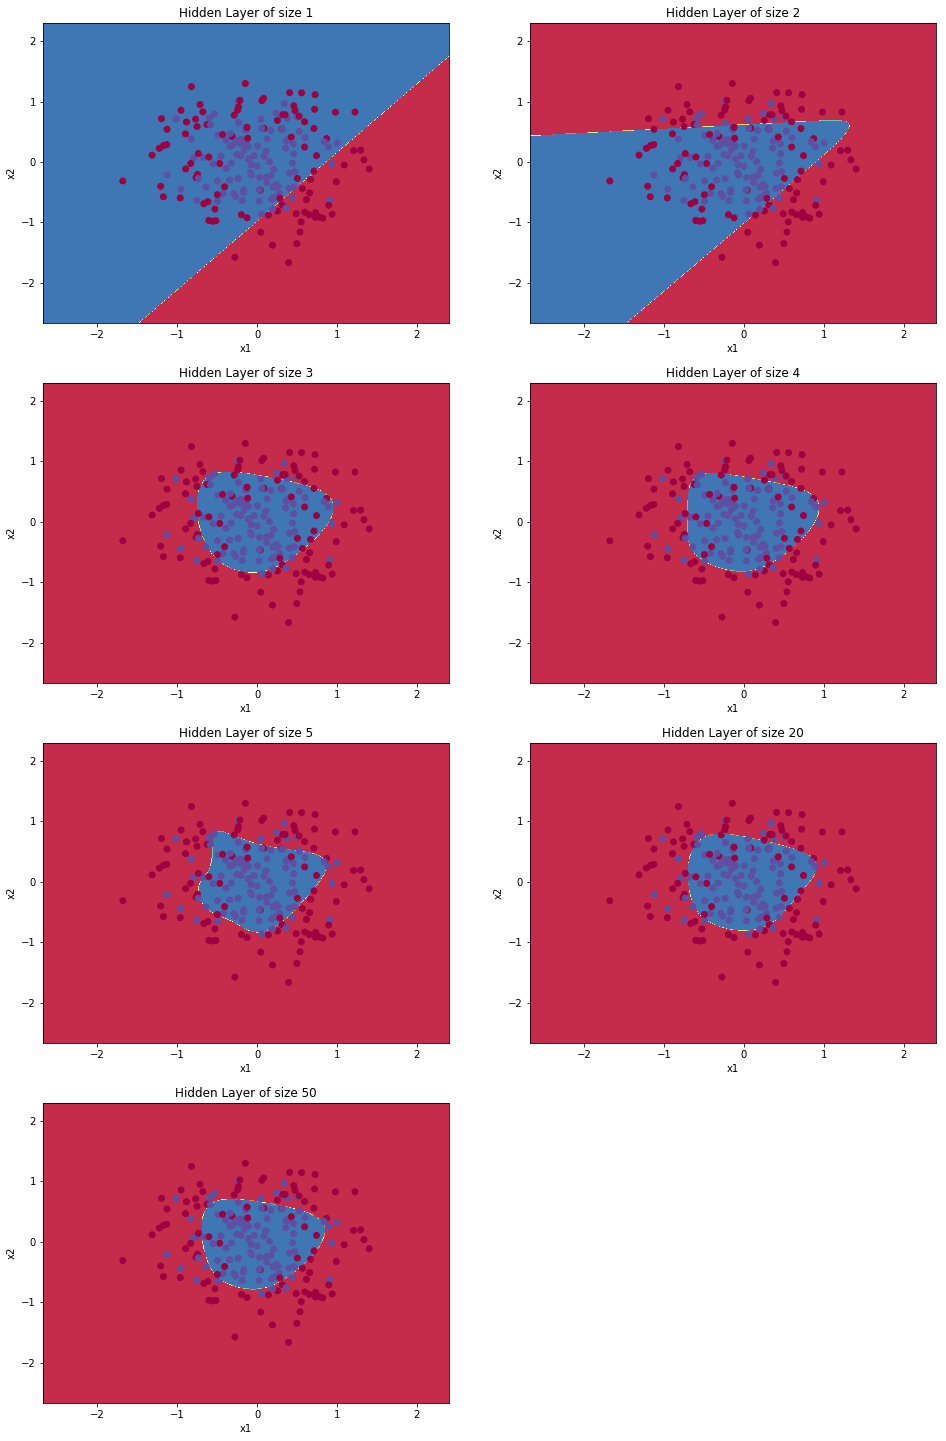

In [27]:
# 隐藏层节点数量调参
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

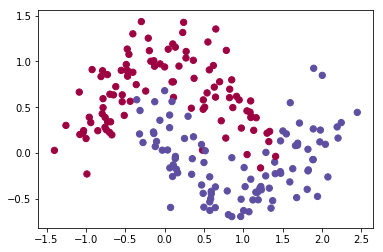

In [28]:
X, Y = noisy_moons
X, Y = X.T, Y.reshape(1, Y.shape[0])

# 绘制样本
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

Accuracy for 1 hidden units: 86.0 %
Accuracy for 2 hidden units: 89.0 %
Accuracy for 3 hidden units: 97.0 %
Accuracy for 4 hidden units: 97.0 %
Accuracy for 5 hidden units: 96.5 %
Accuracy for 20 hidden units: 96.5 %
Accuracy for 50 hidden units: 96.5 %


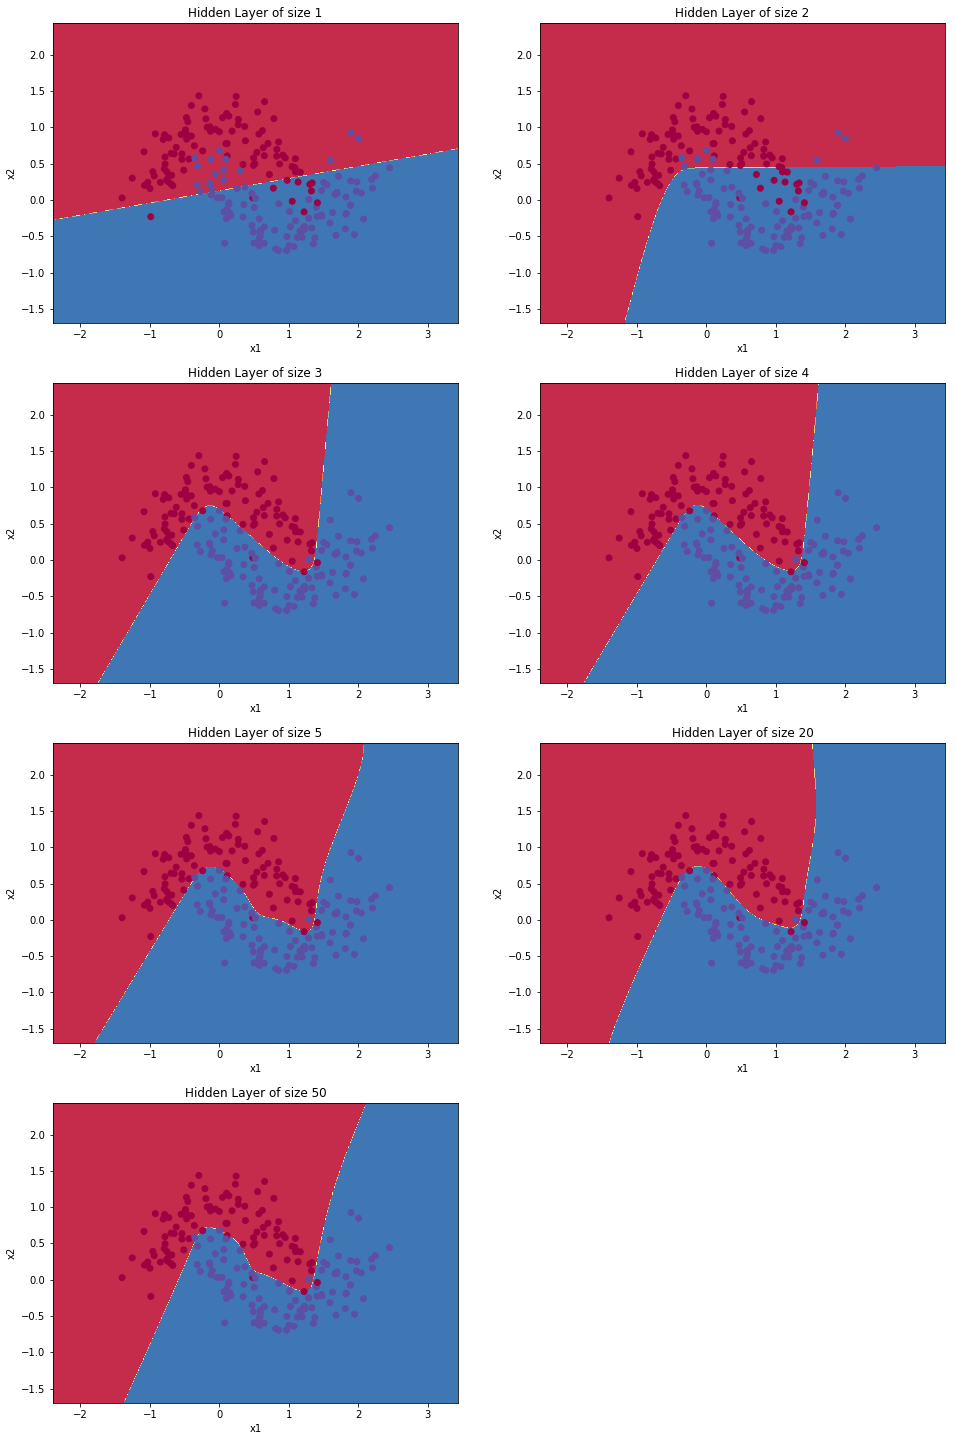

In [29]:
# 隐藏层节点数量调参
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

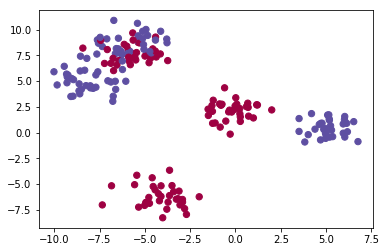

In [30]:
X, Y = blobs
X, Y = X.T, Y.reshape(1, Y.shape[0])
Y = Y%2

# 绘制样本
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

Accuracy for 1 hidden units: 67.0 %
Accuracy for 2 hidden units: 67.0 %
Accuracy for 3 hidden units: 82.5 %
Accuracy for 4 hidden units: 83.0 %
Accuracy for 5 hidden units: 83.0 %
Accuracy for 20 hidden units: 87.5 %
Accuracy for 50 hidden units: 83.5 %


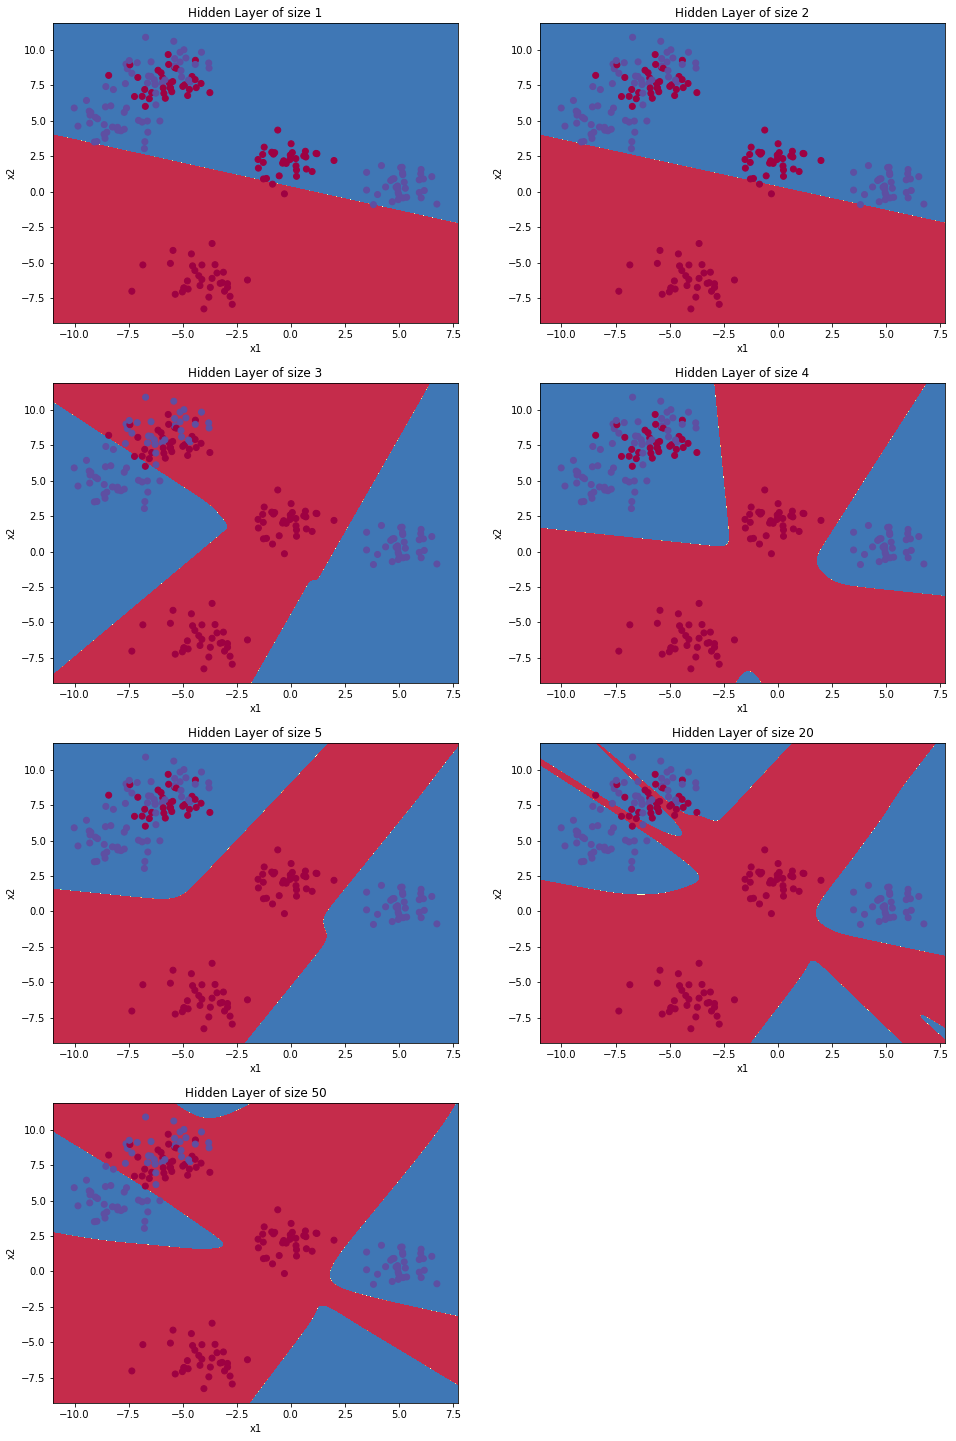

In [31]:
# 隐藏层节点数量调参
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

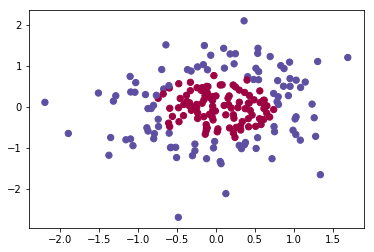

In [32]:
X, Y = gaussian_quantiles
X, Y = X.T, Y.reshape(1, Y.shape[0])

# 绘制样本
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

Accuracy for 1 hidden units: 67.0 %
Accuracy for 2 hidden units: 83.0 %
Accuracy for 3 hidden units: 98.0 %
Accuracy for 4 hidden units: 98.0 %
Accuracy for 5 hidden units: 97.0 %
Accuracy for 20 hidden units: 100.0 %
Accuracy for 50 hidden units: 100.0 %


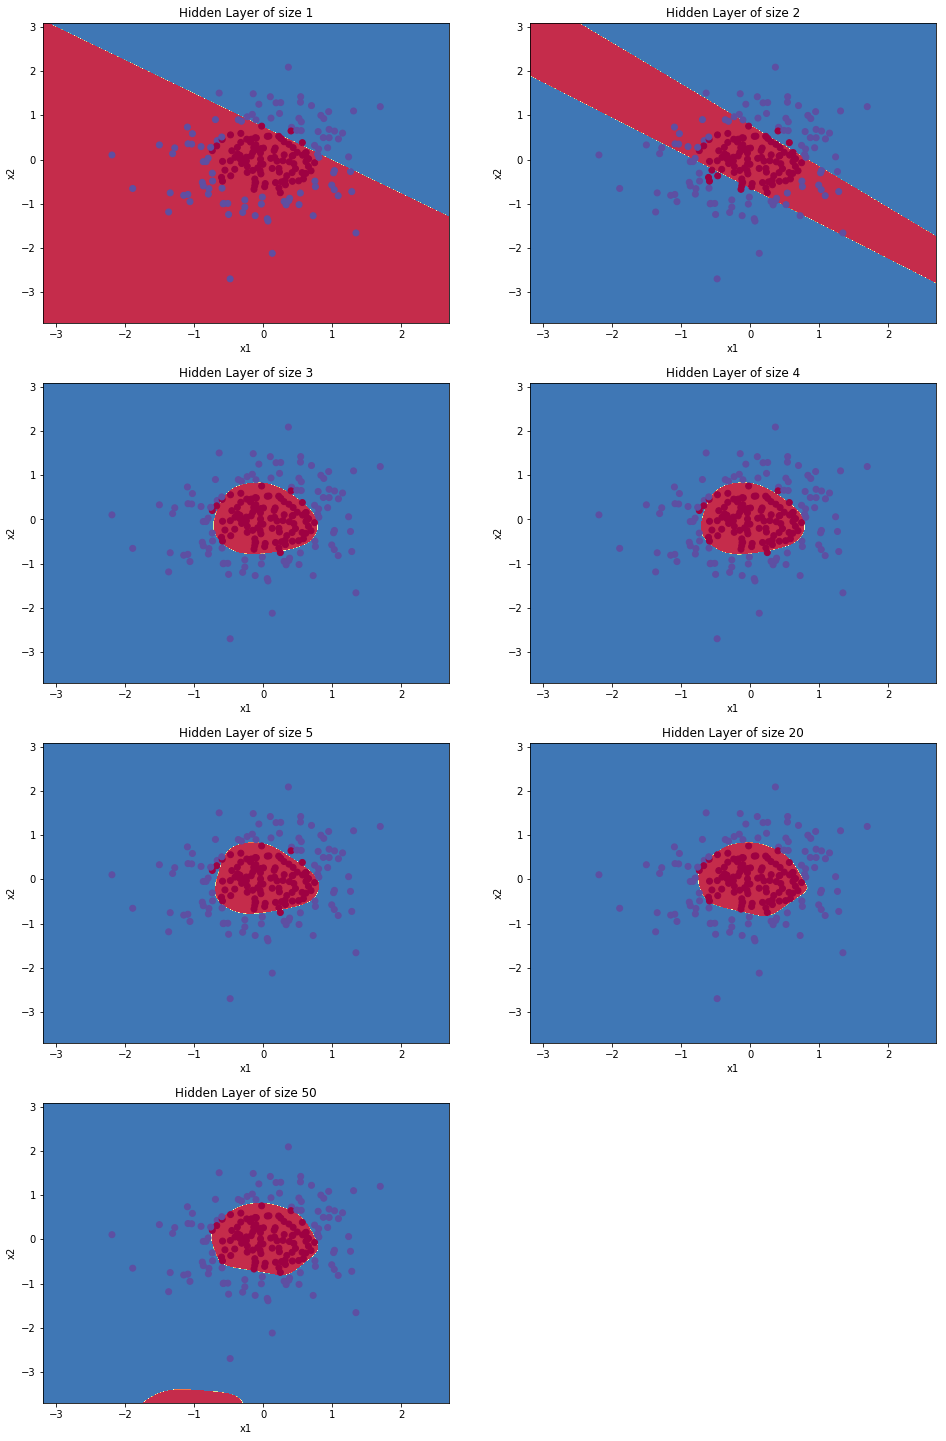

In [33]:
# 隐藏层节点数量调参
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = float((Y @ predictions.T + (1 - Y) @ (1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))